In [1]:
!pip install pycrypto pylfsr ipyplot tinyec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.2/446.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:00
  Created wheel for pycrypto: filename=pycrypto-2.6.1-cp310-cp310-linux_x86_64.whl size=498545 sha256=2898d5a1f082a5a96d47550c4d9cc7e5deb959277c4d89b669e1ad1ba76c3b3a
  Stored in directory: /root/.cache/pip/wheels/e8/4b/5b/b10a6fc885057b6ff9fbd5691d7e700d0a9408f80b7e6f12e0
  Created wheel for tinyec: filename=tinyec-0.4.0-py3-none-any.whl size=20876 sha256=fc794d0f9b6aee0a225f2c716adeedb99eb0c1162169a890797e52b02ddf5439
  Stored in directory: /root/.cache/pip/wheels/02/37/a5/aa011cfa66451de6aa2dbccaa3e7862e8290f0946653753265
Successfully built pycrypto tinyec


In [2]:
import pywt
import pywt.data
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import time,math,cv2
from skimage.util import random_noise
from scipy import ndimage, misc
from skimage import metrics
from pylfsr import LFSR
import ipyplot
from scipy import stats
import random

from tinyec import registry,ec
from collections import defaultdict
import math
import secrets
import copy
import struct
from matplotlib.pyplot import imshow
import warnings
%matplotlib inline

SyntaxError: ignored

In [3]:
def nC(wat, ext):
    w, h = wat.shape
    wat = wat.flatten().astype(np.uint32)
    ext = ext.flatten().astype(np.uint32)
    total = 0

    tot = 0
    for i in range(len(wat)):
        tot += np.sum(wat[i] * ext[i])

    tot1 = 0
    for i in range(len(wat)):
        tot1 += np.sum(wat[i] * wat[i])

    tot2 = 0
    for i in range(len(wat)):
        tot2 += np.sum(ext[i] * ext[i])

    total = (tot * tot) / (tot2 * tot1)
    return total

def noisy(image, noise_typ, amount=0.01, mean=0, var=0.01):
    if noise_typ == "gaussian":
        row,*_= image.shape
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,*_))
        gauss = gauss.reshape(row,*_)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        m, n = image.shape
        noisy = image.copy().flatten()

        indices = np.random.randint(0, noisy.size, int(np.floor(0.5 * m * n * amount)))
        noisy[indices] = 0

        indices = np.random.randint(0, noisy.size, int(np.floor(0.5 * m * n * amount)))
        noisy[indices] = 255

        noisy = noisy.reshape(m, n)

        return noisy

In [4]:
def rhu(n, decimals=2):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier
round1=np.vectorize(rhu)

In [ ]:
coverimg = np.array(Image.open('12.bmp').convert('L').resize((512,512)))
cover_img = np.array(Image.open('12.bmp').convert('L').resize((512,512))).astype('single')

## Discrete Wavelet Transform

In [ ]:
#rdwt=pywt.swt2(cover_img, 'db1',level=1)
coeffs = pywt.dwt2(cover_img, 'haar')
LL, (LH, HL, HH) = coeffs

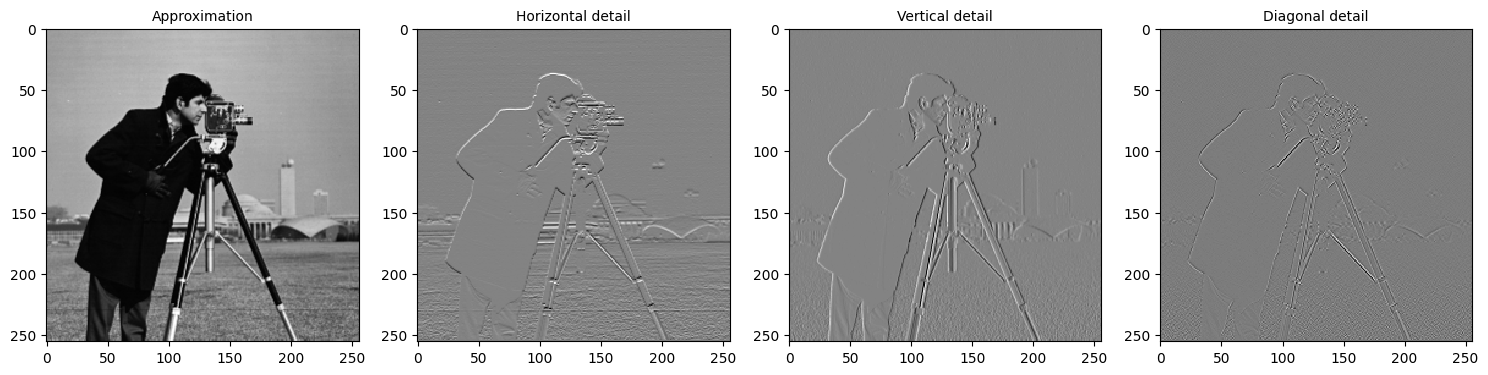

True

In [ ]:
titles = ['Approximation', 'Horizontal detail', 'Vertical detail', 'Diagonal detail']
fig = plt.figure(figsize=(15, 15))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
fig.tight_layout()
plt.show()

cv2.imwrite("LL.png", LL)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Image Watermark Encryption using DNA

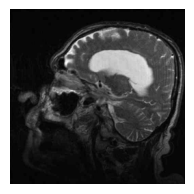

In [ ]:
wimg = np.array(Image.open('jpg30.jpg').convert('L').resize((256,256)))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(wimg, cmap=plt.cm.gray)
fig.tight_layout()
plt.axis('off')
plt.show()

In [ ]:
def hsm2d(a,b,x0,y0,size):
    x=[x0]
    y=[y0]
    for _ in range(size):
        x.append((1 - a*(math.sin(x[-1])**2) + y[-1])%1)
        y.append((b*x[-1])%1)
    return x[1:],y[1:]

In [ ]:
d={
    1:{'00':'A','11':'T','10':'C','01':'G'},
    2:{'00':'A','11':'T','01':'C','10':'G'},
    3:{'11':'A','00':'T','10':'C','01':'G'},
    4:{'11':'A','00':'T','01':'C','10':'G'},
    5:{'10':'A','01':'T','00':'C','11':'G'},
    6:{'01':'A','10':'T','00':'C','11':'G'},
    7:{'10':'A','01':'T','11':'C','00':'G'},
    8:{'01':'A','10':'T','11':'C','00':'G'}
}
d1={
    1:{'A':'00','T':'11','C':'10','G':'01'},
    2:{'A':'00','T':'11','C':'01','G':'10'},
    3:{'A':'11','T':'00','C':'10','G':'01'},
    4:{'A':'11','T':'00','C':'01','G':'10'},
    5:{'A':'10','T':'01','C':'00','G':'11'},
    6:{'A':'01','T':'10','C':'00','G':'11'},
    7:{'A':'10','T':'01','C':'11','G':'00'},
    8:{'A':'01','T':'10','C':'11','G':'00'}
}
def encode(n,rule):
    bn='{0:08b}'.format(n)
    #print(n,rule,bn)
    return d[rule][bn[0:2]]+d[rule][bn[2:4]]+d[rule][bn[4:6]]+d[rule][bn[6:8]]
def decode(n,rule):
    return int(d1[rule][n[0]]+d1[rule][n[1]]+d1[rule][n[2]]+d1[rule][n[3]],2)
x={
    ('A','A') : 'A',
    ('A','T') : 'T',
    ('A','C') : 'C',
    ('A','G') : 'G',
    ('T','A') : 'T',
    ('T','T') : 'A',
    ('T','C') : 'G',
    ('T','G') : 'C',
    ('C','A') : 'C',
    ('C','T') : 'G',
    ('C','C') : 'A',
    ('C','G') : 'T',
    ('G','A') : 'G',
    ('G','T') : 'C',
    ('G','C') : 'T',
    ('G','G') : 'A'
}
def xor(a,b):
    return x[(a[0],b[0])]+x[(a[1],b[1])]+x[(a[2],b[2])]+x[(a[3],b[3])]

In [ ]:
m=256
n=256
x1,y1=hsm2d(55913,11134,31,119,m*n)
x2,y2=hsm2d(10017,7098,243,17,m*n)

In [ ]:
def algo1(p,x1,y1,x2,y2):
    temp=sum(p)%256
    new_p=[]
    for i in range(m*n):
        rx=round(x1[i]*10**10)%8 + 1
        ry=round(y1[i]*10**10)%8 + 1
        rz=round(x2[i]*10**10)%8 + 1
        r=round(y2[i]*10**10)%256
        dnar=encode(r,rz)
        dnap=encode(p[i],ry)
        np=decode(xor(dnap,dnar),rx)
        new_p.append(np^temp)
        #print("np",np,temp,new_p[i])
        temp=np^temp
    return new_p

In [ ]:
def algo2(p,x1):
    s=[]
    di=defaultdict(bool)
    for i in range(m*n):
        si=round(x1[i]*10**10)%m*n + 1
        if not di[si]:
            s.append(si)
            di[si]=True
        else:
            s.append(None)
    rem=[]
    #print(s)
    for i in range(1,m*n + 1):
        if not di[i]:
            rem.append(i)
    #print(rem)
    j=0
    for i in range(m*n):
        if s[i]==None:
            s[i]=rem[j]
            j+=1
    #print(s)
    c=[0]*(m*n)
    for i in range(m*n):
        c[s[i]-1]=p[i]
    return c

In [ ]:
#start_dna=time.time()
p=[]
for i in range(n):
    for j in range(m):
        p.append(wimg[j][i])
#print(p)

In [ ]:
new_p=algo1(p,x1,y1,x2,y2)
c=algo2(new_p,x1)
len(c)

65536

In [ ]:
dna_img=np.array([[0]*m for _ in range(n)])
ind=0
for i in range(n):
    for j in range(m):
        #print(ind)
        dna_img[j][i]=c[ind]
        ind+=1
#print(time.time()-start_dna)

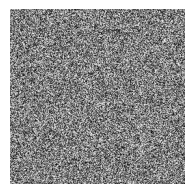

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(dna_img, cmap=plt.cm.gray)
fig.tight_layout()
plt.axis('off')
plt.show()

## Image Watermark Embedding in LL sub band

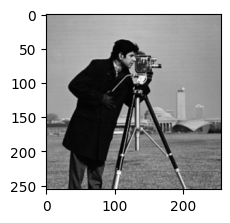

float32


In [ ]:
# Adding Image Watermark
alpha = np.float32(0.01)
WLL = deepcopy(LL)
for i in range(256):
    for j in range(256):
        WLL[i][j] = WLL[i][j] + alpha*(dna_img[i][j])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(WLL, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()
print(WLL.dtype)

## Watermarked Image

float32


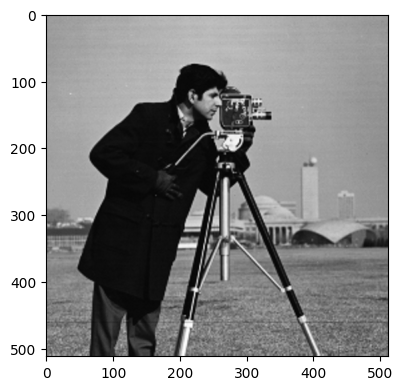

In [ ]:
LL = deepcopy(WLL)
#HL = deepcopy(WHL)
fimg = np.array(pywt.waverec2([LL, (LH, HL, HH)], 'haar', mode='periodization'))
print(fimg.dtype)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(fimg, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()
Image.fromarray(fimg).save("watermarked.tif")

## MSE, PSNR, SSIM

In [5]:
print("MSE ",metrics.mean_squared_error(coverimg, fimg))
print("PSNR ",metrics.peak_signal_noise_ratio(coverimg, fimg))
print("SSIM ",metrics.structural_similarity(coverimg, fimg))

NameError: ignored

## ECC Encryption of Watermarked Image

In [ ]:
warnings.filterwarnings('ignore')
def float_to_bin(num):
    return bin(struct.unpack('!I', struct.pack('!f', num))[0])[2:].zfill(32)
ftb = np.vectorize(float_to_bin)

def bin_to_float(bi):
    return np.float32(struct.unpack('!f',struct.pack('!I', int(bi, 2)))[0])
btf = np.vectorize(bin_to_float)

def bin_to_decimal(bi):
    return np.int32(int(str(bi[:31]),2))
btd = np.vectorize(bin_to_decimal)

def decimal_to_bin(num):
    return (bin(num)[2:].zfill(31)).ljust(32,'0')
dtb = np.vectorize(decimal_to_bin)

In [ ]:
curve = registry.get_curve('brainpoolP512r1')
privkey = secrets.randbelow(curve.field.n)
pubkey = privkey * curve.g
cipherprivkey = secrets.randbelow(curve.field.n)
cipherpubkey = cipherprivkey * curve.g
sharedkey = cipherpubkey * privkey

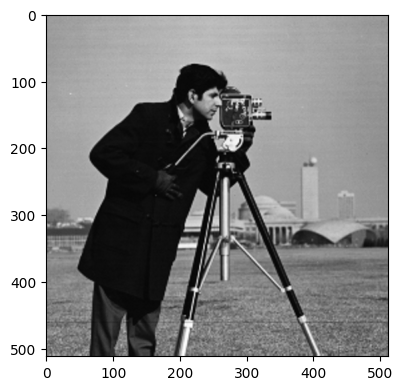

In [ ]:
ecc_img=np.array(Image.open('watermarked.tif'))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(ecc_img, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()

In [ ]:
# ecc_img = noisy(ecc_img, 'gaussian', mean=0, var=0.01)
# ecc_img = noisy(ecc_img, 's&p', amount=0.01)

In [ ]:


#start_ecc=time.time()
bimg = ftb(ecc_img)
dimg = btd(bimg)
# print(dimg)

flattenimg = dimg.flatten()

testimg = copy.deepcopy(flattenimg)
flattenimg.resize(16384,16)
#flattenimg

In [ ]:
imglist = []
for i in range(16384):
    k,t = 0,1
    for j in range(15,-1,-1):
        k+=flattenimg[i][j]*t
        t=t*4294967296
    imglist.append(k)
len(imglist)

16384

In [ ]:
enclist = []
k = 1
for i in range(0,16384,2):
    point = ec.Point(curve,imglist[i],imglist[i+1])
    cipherpoint = point + (k * sharedkey)
    enclist.append(cipherpoint)
#     k+=1
print(len(enclist))

8192


In [ ]:
encimg = []
for i in range(8192):
    temp = []
    k = enclist[i].x
    for j in range(16):
        temp.append(k%4294967296)
        k=k//4294967296
    for j in range(15,-1,-1):
        encimg.append(temp[j])
    if(k>0):
        print(i,k)
    temp = []
    k = enclist[i].y
    for j in range(16):
        temp.append(k%4294967296)
        k=k//4294967296
    for j in range(15,-1,-1):
        encimg.append(temp[j])
    if(k>0):
        print(i,k)

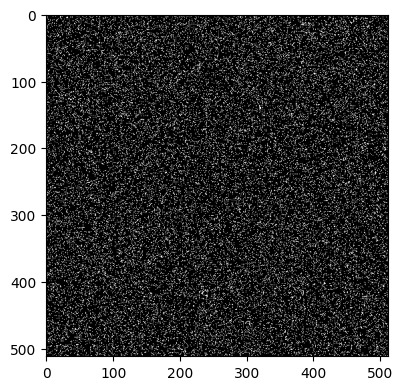

In [ ]:
bimg = dtb(encimg)
fimg = btf(bimg)
#print(time.time()-start_ecc)
enci = np.array(fimg)
enci.resize(512,512)
Img = Image.fromarray(enci)
Img.save('enci.tif')
Img.convert('L').save('enci.png')
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(Image.open('enci.png'), cmap=plt.cm.gray)
fig.tight_layout()
plt.show()

## ECC Decryption

In [ ]:
#end_ecc = time.time()
declist = []
k = 1
for i in range(8192):
    point = enclist[i] - (k * sharedkey)
    declist.append(point)
#     k+=1
print(len(declist))

8192


In [ ]:
decimg = []
for i in range(8192):
    temp = []
    k = declist[i].x
    for j in range(16):
        temp.append(k%4294967296)
        k=k//4294967296
    for j in range(15,-1,-1):
        decimg.append(temp[j])
    temp = []
    k = declist[i].y
    for j in range(16):
        temp.append(k%4294967296)
        k=k//4294967296
    for j in range(15,-1,-1):
        decimg.append(temp[j])
len(decimg)

262144

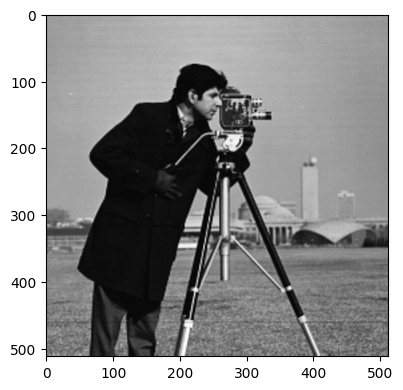

In [ ]:
bimg = dtb(decimg)
fimg = btf(bimg)
#print(time.time()-end_ecc)

deci = np.array(fimg)
deci.resize(512,512)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(deci, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()
# Image.fromarray(deci).save("deci.tif")
Img = Image.fromarray(deci)
Img.save('deci.tif')
#Img.show()
#deci

## Extraction of Image Watermark from LL sub-band

In [ ]:
img=np.array(Image.open('watermarked.tif'))
dec_img=np.array(Image.open('deci.tif'))

In [ ]:
coeffs = pywt.dwt2(dec_img, 'haar')
iLL, (iLH, iHL, iHH) = coeffs
#print(iLH==LH)
coeffs = pywt.dwt2(cover_img, 'haar')
LL, (LH, HL, HH) = coeffs
LL.dtype,iLL.dtype,LL.shape,iLL.shape

(dtype('float32'), dtype('float32'), (256, 256), (256, 256))

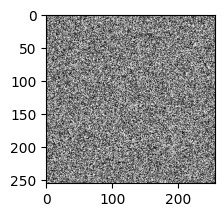

In [ ]:
FWLL = np.zeros([256,256]).astype('single')
for i in range(256):
    for j in range(256):
        FWLL[i][j] = (iLL[i][j]-LL[i][j])/alpha
#FWLL=round(FWLL)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(FWLL, cmap=plt.cm.gray)

In [ ]:
FWLL=round1(FWLL,0).astype(int)
FWLL.dtype

dtype('int64')

## Decryption of Image Watermark

In [ ]:
cc=[]
for i in range(n):
    for j in range(m):
        cc.append(FWLL[j][i])

In [ ]:
def d_algo1(c,x1,y1,x2,y2):
    dd=[0]*(m*n)
    dd[0]=c[0]
    for i in range(1,m*n):
        temp=c[i-1]
        rx=round(x1[i]*10**10)%8 + 1
        ry=round(y1[i]*10**10)%8 + 1
        rz=round(x2[i]*10**10)%8 + 1
        r=round(y2[i]*10**10)%256
        dnar=encode(r,rz)
        dd[i]=c[i]^temp
        dd[i]=encode(dd[i],rx)
        dd[i]=xor(dd[i],dnar)
        dd[i]=decode(dd[i],ry)
    return dd

In [ ]:
def d_algo2(p,x1):
    s=[]
    di=defaultdict(bool)
    for i in range(m*n):
        si=round(x1[i]*10**10)%m*n + 1
        if not di[si]:
            s.append(si)
            di[si]=True
        else:
            s.append(None)
    rem=[]
    for i in range(1,m*n + 1):
        if not di[i]:
            rem.append(i)
    #print(rem,s)
    j=0
    for i in range(m*n):
        if s[i]==None:
            s[i]=rem[j]
            j+=1
    #print(s)
    de=[0]*(m*n)
    for i in range(m*n):
        de[i]=p[s[i]-1]
    return de

In [ ]:
#end_dna=time.time()
de=d_algo2(cc,x1)
tt=d_algo1(de,x1,y1,x2,y2)

In [ ]:
decImg=np.array([[0]*m for _ in range(n)])
ind=0
for i in range(n):
    for j in range(m):
        decImg[j][i]=tt[ind]
        ind+=1
#print(time.time()-end_dna)

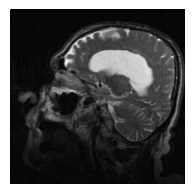

NC: 0.9997955514867135


In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(decImg, cmap=plt.cm.gray)
fig.tight_layout()
plt.axis('off')
plt.show()

print("NC:", nC(wimg,decImg))

In [ ]:
#Multilevel security

#npcr uaci
#histogram analysis (original watermark, encrypted watermark, decrypted watermark)
#entropy (encrypted watermark 7.99 approx)
#correlation analysis (encrypted watermark/plain watermark horizontal, vertical diagonal)
#key sensitivity (change key valye by 1/2 bit)

## Histogram Analysis

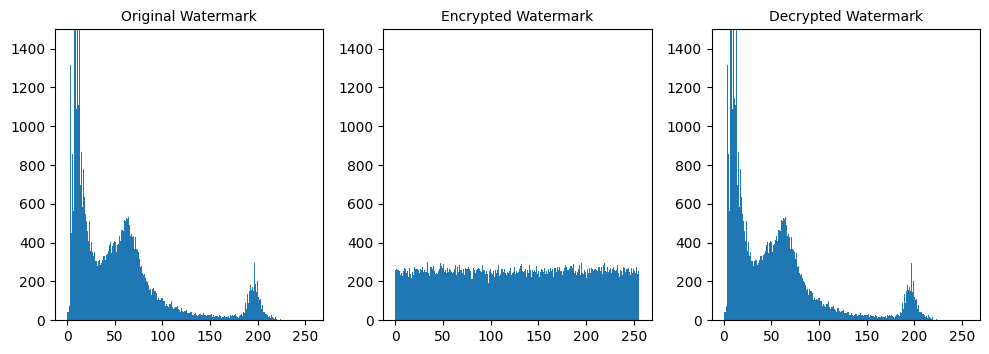

In [ ]:
titles = ['Original Watermark', 'Encrypted Watermark', 'Decrypted Watermark']
fig = plt.figure(figsize=(10, 10))
for i, a in enumerate([wimg,dna_img,decImg]):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.hist(a.ravel(),256,[0,256])
    plt.ylim(0, 1500)
    ax.set_title(titles[i], fontsize=10)
fig.tight_layout()
plt.show()

## Entropy

In [ ]:
def entropy(signal):
        '''
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        lensig=signal.size
        symset=list(set(signal))
        numsym=len(symset)
        propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return ent

In [ ]:
entropy(wimg.ravel())

5.983695093426959

In [ ]:
entropy(dna_img.ravel())

7.996925548114574

## Correlation Analysis

In [ ]:
def correlationH():
    titles = ['Horizontal - Plain Watermark', 'Horizontal - Encrypted Watermark']
    fig = plt.figure(figsize=(10, 10))
    for i, a in enumerate([wimg,dna_img]):
        x1 = a[:,0:-1].ravel()
        y1 = a[:,1:].ravel()
        randindex=np.random.permutation(x1.size)[:4000]
        x11 = x1[randindex]
        y11 = y1[randindex]
        ax = fig.add_subplot(3, 2, i + 1)
        ax.scatter(x11,y11,s=1)
        ax.set_title(titles[i]+" Coefficient "+str(stats.spearmanr(x11, y11)[0]), fontsize=10)
    fig.tight_layout()
    plt.show()
def correlationV():
    titles = ['Vertical - Plain Watermark', 'Vertical - Encrypted Watermark']
    fig = plt.figure(figsize=(10, 10))
    for i, a in enumerate([wimg,dna_img]):
        x1 = a[0:-1,:].ravel()
        y1 = a[1:,:].ravel()
        randindex=np.random.permutation(x1.size)[:4000]
        x11 = x1[randindex]
        y11 = y1[randindex]
        ax = fig.add_subplot(3, 2, i + 1)
        ax.scatter(x11,y11,s=1)
        ax.set_title(titles[i]+" Coefficient "+str(stats.spearmanr(x11, y11)[0]), fontsize=10)
    fig.tight_layout()
    plt.show()
def correlationD():
    titles = ['Diagonal - Plain Watermark', 'Diagonal - Encrypted Watermark']
    fig = plt.figure(figsize=(10, 10))
    for i, a in enumerate([wimg,dna_img]):
        x1 = a[0:-1,0:-1].ravel()
        y1 = a[1:,1:].ravel()
        randindex=np.random.permutation(x1.size)[:4000]
        x11 = x1[randindex]
        y11 = y1[randindex]
        ax = fig.add_subplot(3, 2, i + 1)
        ax.scatter(x11,y11,s=1)
        ax.set_title(titles[i]+" Coefficient "+str(stats.spearmanr(x11, y11)[0]), fontsize=10)
    fig.tight_layout()
    plt.show()

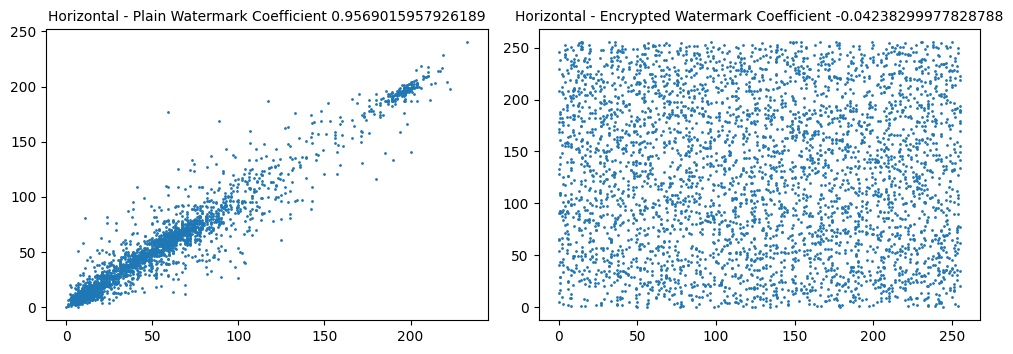

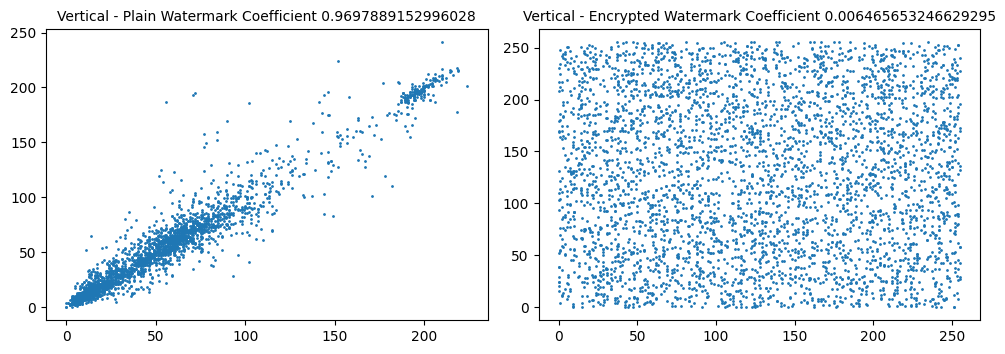

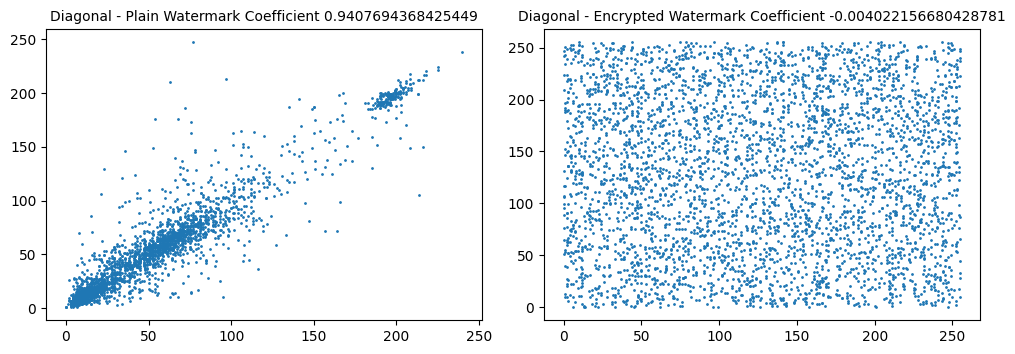

In [ ]:
correlationH()
correlationV()
correlationD()

## Key Sensitivity Analysis

In [ ]:
changedx1,changedy1=hsm2d(55913.00000000001,11134,31,119,m*n)
changedx2,changedy2=hsm2d(10017,7098,243,17,m*n)

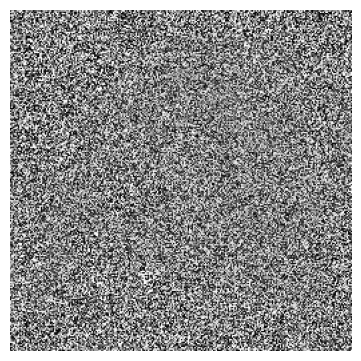

In [ ]:
changed_tt=d_algo1(d_algo2(cc,changedx1),changedx1,changedy1,changedx2,changedy2)
changed_decImg=np.array([[0]*m for _ in range(n)])
ind=0
for i in range(n):
    for j in range(m):
        changed_decImg[j][i]=changed_tt[ind]
        ind+=1
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(changed_decImg, cmap=plt.cm.gray)
fig.tight_layout()
plt.axis('off')
plt.show()